<a href="https://colab.research.google.com/github/AdamClarkStandke/GenerativeDeepLearning/blob/main/StableDiffustion_Text2Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Conditional Latent Diffusion Model (Stable Diffusion)



---

## Background

Stable Diffusion stems from the paper [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/pdf/2112.10752.pdf) a joint project between [Ludwig Maximilian University of Munich & IWR](https://ommer-lab.com/) and [Runway ML](https://runwayml.com/). Stable Diffusion is a form of Multimodal Learning which most people (namely me) consider to be the future of generative learning. As stated in [Generative Deep Learning: Teaching Machines To Paint, Write, Compose, and Play](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=asc_df_1098134184/?tag=hyprod-20&linkCode=df0&hvadid=632163212339&hvpos=&hvnetw=g&hvrand=14059992483304092225&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=9006587&hvtargid=pla-1852750701094&psc=1&mcid=e1431dcee2ae37808a9d62e277627154&gclid=Cj0KCQiAkKqsBhC3ARIsAEEjuJj0ac3q0MjvImuQ2N8gFCvcZAO9DwPeKXhdMyDrXfNHztPzxH2kaO4aApI3EALw_wcB):

> Multimodal learning involves training generative models to convert between two or more different kinds of data.Some of the most impressive generative models introduced in the last two years have been multimodal in nature...we will explore how they work in detail and consider *how the future of generative modeling will be shaped by large multimodal models*(emphasis added).

What seperates Stable Diffusion from other text to image multimodal models such as DALL.E and Imagen is that Stable Diffusion wraps an Auto-Encoder architecture over a diffusion model so that the diffusion process takes place in latent space. This allows for significant computational advantages not present in other multimodal models. As the authors from [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/pdf/2112.10752.pdf) state:


> [W]e utilize an autoencoding model which learns a space that is perceptually equivalent to the image space, but offers significantly reduced computational complexity.Such an approach offers several advantages: (i) *By leaving the high-dimensional image space, we obtain DMs which are computationally much more efficient because sampling is performed on a low-dimensional space* (emphasis added).

To train Stable Diffusion from sratch the Autoencoder must first be trained. As the authors from [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/pdf/2112.10752.pdf) state:


> We train all our autoencoder models in an adversarial manner...such that a patch-based discriminator $D_{\Psi }$ is optimized to differentiate original images from reconstructions $D(E(x))$ To avoid arbitrarily scaled latent spaces, we regularize the latent *z* to be zero centered and obtain small
> variance by introducing an regularizing loss term $L_{regularization}$...[which is]  a low-weighted Kullback-Leibler-term between $q_{E}(z|x)= N(z;E_{\mu}, E_{σ^2})$ and a standard normal distribution...[t]he full objective to train the autoencoding model (E, D) reads:
\begin{align} L_{Autoencoder}=min_{E,D}max_{\psi}(L_{reconstruction}(x, D(E(x)))-L_{adversarial}(D(E(x)))+logD_{\psi} +L_{regularization}(x;E,D)) \end{align}

After training the Autoencoder from scratch there are different approaches one can take to train a text-conditional latent diffusion model. One approch as detailed in the paper is to jointly train the diffusion model and an unmasked transformer.

As the authors from [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/pdf/2112.10752.pdf) state:

> Based on image-conditioning pairs, we then learn the conditional LDM via $L_{LDM}=\mathbb{E}_{E(x),y,\epsilon\sim N(0,1), t}[\parallel \epsilon-\epsilon_{\theta}(z_t, t, τ_{θ}(y))\parallel^2_2]$ where both $τ_{θ}$ and $\epsilon_{\theta}$ are jointly optimized [note: this was not done in the intial relase rather $τ_{θ}$ was a pre-trained Clip model]...[t]his conditioning mechanism is flexible as $τ_{θ}$ can be parameterized with domain-specific experts, e.g. (unmasked) transformers...where y are text prompts

> For text-to-image modeling, we train a 1.45B parameter KL-regularized LDM conditioned on language prompts on [LAION-400M](https://laion.ai/)...[w]e employ the BERT-tokenizer...and implement $τ_{θ}$ as a transformer...to infer a latent code which is mapped into the UNet via (multi-head) cross-attention.

These are some of the hyperparameters used by the authors from [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/pdf/2112.10752.pdf) when training their text-conditional LDM (i.e. Stable Diffusion):

**Hyperparameters of Conditional Latent Diffusion Model:**

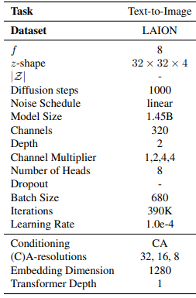

**Hyperparameters of Unmasked Transformer:**

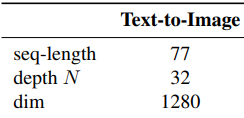










---


## Stable Diffusion v1-4 Model


I will not be training from sratch the text-conditional LDM (Stable Diffusion) but will be loading the pre-trained model as found at [Stable-Diffusion-v1-4 ](https://huggingface.co/CompVis/stable-diffusion-v1-4).
As the authors of [Stable-Diffusion-v1-4 ](https://huggingface.co/CompVis/stable-diffusion-v1-4) state:

> The Stable-Diffusion-v1-4 checkpoint was initialized with the weights of the Stable-Diffusion-v1-2 checkpoint and subsequently fine-tuned on 225k steps at resolution 512x512 on ["laion-aesthetics v2 5+"](https://laion.ai/blog/laion-aesthetics/) and *10% dropping of the text-conditioning* to improve [classifier-free guidance sampling](https://arxiv.org/pdf/2207.12598.pdf)...the model uses a fixed, pretrained text encoder ([CLIP ViT-L/14](https://arxiv.org/pdf/2103.00020.pdf)) as suggested in the [Imagen paper](https://arxiv.org/pdf/2205.11487.pdf)

I will now try and detail the [training procedure](https://huggingface.co/CompVis/stable-diffusion-v1-4) of the v1-4 model with some [code snippets](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L25):

1.   Images are encoded through an encoder, which turns images into latent representations. The autoencoder uses a relative downsampling factor of 8 and maps images of shape H x W x 3 to latents of shape H/f x W/f x 4

**[Image Encoder](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/autoencoders/autoencoder_kl.py)**

```
class AutoencoderKL(ModelMixin, ConfigMixin, FromOriginalVAEMixin):
    """
    A VAE model with KL loss for encoding images into latents and decoding latent representations into images.

    def encode(
        self, x: torch.FloatTensor, return_dict: bool = True
    ) -> Union[AutoencoderKLOutput, Tuple[DiagonalGaussianDistribution]]:
        """
        Encode a batch of images into latents.

        Args:
            x (`torch.FloatTensor`): Input batch of images.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether to return a [`~models.autoencoder_kl.AutoencoderKLOutput`] instead of a plain tuple.

        Returns:
                The latent representations of the encoded images. If `return_dict` is True, a
                [`~models.autoencoder_kl.AutoencoderKLOutput`] is returned, otherwise a plain `tuple` is returned.
        """
        if self.use_tiling and (x.shape[-1] > self.tile_sample_min_size or x.shape[-2] > self.tile_sample_min_size):
            return self.tiled_encode(x, return_dict=return_dict)

        if self.use_slicing and x.shape[0] > 1:
            encoded_slices = [self.encoder(x_slice) for x_slice in x.split(1)]
            h = torch.cat(encoded_slices)
        else:
            h = self.encoder(x)

        moments = self.quant_conv(h)
        posterior = DiagonalGaussianDistribution(moments)

        if not return_dict:
            return (posterior,)

        return AutoencoderKLOutput(latent_dist=posterior)    

```

2.   Text prompts are encoded through a [ViT-L/14]((https://arxiv.org/pdf/2103.00020.pdf) text-encoder which consists of the follwoing:

> The text encoder is a Transformer...[a]s a base size we use a 63M-parameter 12-layer 512-wide model with 8 attention heads. The transformer operates on a lower-cased byte pair encoding (BPE) representation of the text with a 49,152 vocab size...[f]or computational efficiency, the max sequence length was capped at 76. The text sequence is bracketed with [SOS] and [EOS] tokens and the activations of the highest layer of the transformer at the [EOS] token are treated as the feature representation of the text which is layer normalized and then *linearly projected into the multi-modal embedding space*(emphasis added).

**[ViT-L/14](https://github.com/huggingface/transformers/blob/main/src/transformers/models/clip/modeling_clip.py#L751)**
```
 """The text model from CLIP without any head or projection on top.""",
    CLIP_START_DOCSTRING,
)
class CLIPTextModel(CLIPPreTrainedModel):
    config_class = CLIPTextConfig

    _no_split_modules = ["CLIPTextEmbeddings", "CLIPEncoderLayer"]

    def __init__(self, config: CLIPTextConfig):
        super().__init__(config)
        self.text_model = CLIPTextTransformer(config)
        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self) -> nn.Module:
        return self.text_model.embeddings.token_embedding

    def set_input_embeddings(self, value):
        self.text_model.embeddings.token_embedding = value

    @add_start_docstrings_to_model_forward(CLIP_TEXT_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=BaseModelOutputWithPooling, config_class=CLIPTextConfig)
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPooling]:
        r"""
        Returns:

        Examples:

        ```python
        >>> from transformers import AutoTokenizer, CLIPTextModel

        >>> model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
        >>> tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

        >>> inputs = tokenizer(["a photo of a cat", "a photo of a dog"], padding=True, return_tensors="pt")

        >>> outputs = model(**inputs)
        >>> last_hidden_state = outputs.last_hidden_state
        >>> pooled_output = outputs.pooler_output  # pooled (EOS token) states
        ```"""
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        return self.text_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

```

3.   The non-pooled output of the text encoder is fed into the UNet backbone of the latent diffusion model via cross-attention.


**[latent diffusion model](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L118)**
```
def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        timesteps: List[int] = None,
        guidance_scale: float = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        ip_adapter_image: Optional[PipelineImageInput] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        guidance_rescale: float = 0.0,
        clip_skip: Optional[int] = None,
        callback_on_step_end: Optional[Callable[[int, int, Dict], None]] = None,
        callback_on_step_end_tensor_inputs: List[str] = ["latents"],
        **kwargs,
    ):
        r"""
        The call function to the pipeline for generation.
        """

        callback = kwargs.pop("callback", None)
        callback_steps = kwargs.pop("callback_steps", None)

        if callback is not None:
            deprecate(
                "callback",
                "1.0.0",
                "Passing `callback` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`",
            )
        if callback_steps is not None:
            deprecate(
                "callback_steps",
                "1.0.0",
                "Passing `callback_steps` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`",
            )

        # 0. Default height and width to unet
        height = height or self.unet.config.sample_size * self.vae_scale_factor
        width = width or self.unet.config.sample_size * self.vae_scale_factor
        # to deal with lora scaling and other possible forward hooks

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt,
            height,
            width,
            callback_steps,
            negative_prompt,
            prompt_embeds,
            negative_prompt_embeds,
            callback_on_step_end_tensor_inputs,
        )

        self._guidance_scale = guidance_scale
        self._guidance_rescale = guidance_rescale
        self._clip_skip = clip_skip
        self._cross_attention_kwargs = cross_attention_kwargs
        self._interrupt = False

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device

        # 3. Encode input prompt
        lora_scale = (
            self.cross_attention_kwargs.get("scale", None) if self.cross_attention_kwargs is not None else None
        )

        prompt_embeds, negative_prompt_embeds = self.encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            self.do_classifier_free_guidance,
            negative_prompt,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            lora_scale=lora_scale,
            clip_skip=self.clip_skip,
        )

        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        if self.do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

        if ip_adapter_image is not None:
            output_hidden_state = False if isinstance(self.unet.encoder_hid_proj, ImageProjection) else True
            image_embeds, negative_image_embeds = self.encode_image(
                ip_adapter_image, device, num_images_per_prompt, output_hidden_state
            )
            if self.do_classifier_free_guidance:
                image_embeds = torch.cat([negative_image_embeds, image_embeds])

        # 4. Prepare timesteps
        timesteps, num_inference_steps = retrieve_timesteps(self.scheduler, num_inference_steps, device, timesteps)

        # 5. Prepare latent variables
        num_channels_latents = self.unet.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 6.1 Add image embeds for IP-Adapter
        added_cond_kwargs = {"image_embeds": image_embeds} if ip_adapter_image is not None else None

        # 6.2 Optionally get Guidance Scale Embedding
        timestep_cond = None
        if self.unet.config.time_cond_proj_dim is not None:
            guidance_scale_tensor = torch.tensor(self.guidance_scale - 1).repeat(batch_size * num_images_per_prompt)
            timestep_cond = self.get_guidance_scale_embedding(
                guidance_scale_tensor, embedding_dim=self.unet.config.time_cond_proj_dim
            ).to(device=device, dtype=latents.dtype)

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        self._num_timesteps = len(timesteps)
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                if self.interrupt:
                    continue

                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if self.do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                noise_pred = self.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    timestep_cond=timestep_cond,
                    cross_attention_kwargs=self.cross_attention_kwargs,
                    added_cond_kwargs=added_cond_kwargs,
                    return_dict=False,
                )[0]

                # perform guidance
                if self.do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

                if self.do_classifier_free_guidance and self.guidance_rescale > 0.0:
                    # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
                    noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=self.guidance_rescale)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]

                if callback_on_step_end is not None:
                    callback_kwargs = {}
                    for k in callback_on_step_end_tensor_inputs:
                        callback_kwargs[k] = locals()[k]
                    callback_outputs = callback_on_step_end(self, i, t, callback_kwargs)

                    latents = callback_outputs.pop("latents", latents)
                    prompt_embeds = callback_outputs.pop("prompt_embeds", prompt_embeds)
                    negative_prompt_embeds = callback_outputs.pop("negative_prompt_embeds", negative_prompt_embeds)

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        step_idx = i // getattr(self.scheduler, "order", 1)
                        callback(step_idx, t, latents)

        if not output_type == "latent":
            image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False, generator=generator)[
                0
            ]
            image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)
        else:
            image = latents
            has_nsfw_concept = None

        if has_nsfw_concept is None:
            do_denormalize = [True] * image.shape[0]
        else:
            do_denormalize = [not has_nsfw for has_nsfw in has_nsfw_concept]

        image = self.image_processor.postprocess(image, output_type=output_type, do_denormalize=do_denormalize)

        # Offload all models
        self.maybe_free_model_hooks()

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)
```


4.   The loss is a reconstruction objective between the noise that was added to the latent and the prediction made by the UNet.




---

## How to Generate Images using the Stable Diffusion Pipeline


To get started enter some text in the `Text_Promt` (e.g. Standke family crest , Germany, medieval times). To make sure that Stable Diffusion can run for free on Colab do not check the `ColabProPlus` box. This will change the weights associated with Stable Diffusion to 16 bits. Eventhough the image precision will fall, one will be able to run Stable Diffusion using the free version of Colab. One potential workaround  is to check the `VAE_SLICING` and `VAE_TILING` boxes and then check the `ColabProPlus` box. (However I cannot guarantee that this workaround will work everytime.)  

Becasue Stable Diffusion is a non-deterministic generative algorithm running the same text in the `Text_Promt` will produce a different image everytime. If you want to generate the same image everytime check the `Deterministic` box.

[Stable Diffusion](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb)  produces images of 512 × 512 pixels by default. But it's very easy to override the default using the `height` and `width` values, so you can create rectangular images in portrait or landscape ratios.

These are some recommendations to choose good image sizes when changing the `height` and `width` values:

*   Make sure height and width are both multiples of 8.
*   Going below 512 might result in lower quality images.
*   Going over 512 in both directions will repeat image areas (global coherence is lost).
*   The best way to create non-square images is to use 512 in one dimension, and a value larger than that in the other one.

You can change the number of inference steps using the `STEPS` argument. In general, results are better the more steps you use. Stable Diffusion, being one of the latest models, works great with a relatively small number of steps, so we recommend to use the default of 50. If you want faster results you can use a smaller number.

The other parameter in the pipeline call is `GUIDANCE_SCALE`. It is a way to increase the adherence to the conditional signal which in this case is text as well as overall sample quality. In simple terms classifier free guidance forces the generation to better match with the prompt. Numbers like 7 or 8.5 give good results, if you use a very large number the images might look good, but will be less diverse.

Laslty there are three different noise schedulers that adjust and define the denoising process (i.e., the speed and quality of denoising/generating an image).The `LMSDiscreteScheduler`  is a linear multistep scheduler for discrete beta schedules. The `PNDMScheduler` or pseudo numerical method for diffusion models, uses more advanced ODE integration techniques like the Runge-Kutta and linear multi-step method. And the `DDIMScheduler` extends the denoising procedure introduced in denoising diffusion probabilistic models (DDPMs) with non-Markovian guidance.

After choosing which settings work best, run the cell to see what images Stable Diffusion comes up with!!!! 🎨




In [1]:
!pip install --upgrade --quiet diffusers[torch]
!pip install --upgrade --quiet diffusers transformers scipy
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 24.3 MB/s eta 0:00:00


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

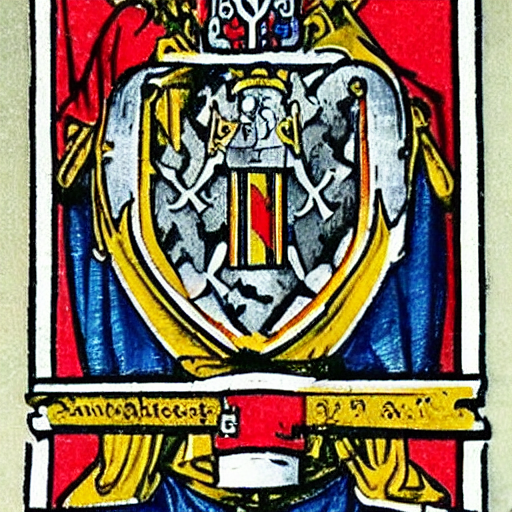

In [2]:
import torch
from diffusers import StableDiffusionPipeline, LMSDiscreteScheduler, PNDMScheduler, DDIMScheduler

model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

# Pipeline Parameters
Text_Prompt = "Standke family crest ,  Germany, medieval times"#@param { type: "string" }
ColabProPlus =  True #@param { type: "boolean" }
Deterministic = False #@param { type: "boolean" }
height = 512  #@param { type: "integer" }
width = 512  #@param { type: "integer" }
VAE_SLICING = True #@param { type: "boolean" }
VAE_TILING = True #@param { type: "boolean" }
STEPS = 50 #@param { type: "integer" }
NOISE_SCHEDULE = "DDIMScheduler" #@param ["PNDM", "LMSDiscrete", "DDIMScheduler"]
GUIDANCE_SCALE = 7.5 #@param { type:"slider", min: 1, max: 14, step: 0.5 }

# Random Seed generation
generator = torch.Generator(device).manual_seed(42)


if ColabProPlus:
  if NOISE_SCHEDULE=="LMSDiscrete":
    scheduler=LMSDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
  if NOISE_SCHEDULE=="DDIMScheduler":
    scheduler=DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")
  if NOISE_SCHEDULE=="PNDM":
    scheduler=PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")
  pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler)
  pipe = pipe.to(device)
else:
  if NOISE_SCHEDULE=="LMSDiscrete":
    scheduler=LMSDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
  if NOISE_SCHEDULE=="DDIMScheduler":
    scheduler=DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")
  if NOISE_SCHEDULE=="PNDM":
    scheduler=PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")
  pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
  pipe = pipe.to(device)
if VAE_SLICING:
  pipe.enable_vae_slicing()
if VAE_TILING:
  pipe.enable_vae_tiling()


if Deterministic:
  image = pipe(Text_Prompt, generator=generator, height=height, width=width, num_inference_steps=STEPS, guidance_scale=GUIDANCE_SCALE).images[0]
else:
  image =  pipe(Text_Prompt, height=height, width=width, num_inference_steps=STEPS, guidance_scale=GUIDANCE_SCALE).images[0]

image.save("/content/generated_art.png")
image



---


# Taking Random Walks Through Stable Diffusion's Latent Space

As David Foster discused with regards to [variational autoencoders](https://github.com/AdamClarkStandke/GenerativeDeepLearning/blob/main/VAE.ipynb) one can do various linear algerbra operations in the latent space to find vectors with a given feature set; and then apply the found feature vector to the orginal latent vector to transform the generated image. Since Stable Diffusion encodes images into a lower dimensional latent space using a variational autoencoder the same principles used for [variational autoencoders](https://github.com/AdamClarkStandke/GenerativeDeepLearning/blob/main/VAE.ipynb) can be applied to latent diffusion models (i.e., Stable Diffusion).

This code has been cloned from Alen Smajic's notebook titled [Stable-Diffusion-Latent-Space-Explorer](https://github.com/alen-smajic/Stable-Diffusion-Latent-Space-Explorer) and will be running the experiment random walk. The model paramaters (for now) are defined in the file random_walk.yaml which can be found in my repo. This file must be passed into the class `Txt2Img` to output similar images from the latent space found in the same direction. In the end a cool gif can be created!!!! 💥



In [ ]:
!pip install --upgrade --quiet diffusers[torch]
!pip install --upgrade --quiet diffusers transformers scipy
!pip install accelerate

In [ ]:
# !git clone https://github.com/alen-smajic/Stable-Diffusion-Latent-Space-Explorer

In [5]:
import yaml
import random
import torch
from torchvision import transforms
import diffusers
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
from datetime import datetime
import shutil
import os

In [19]:
with open("/content/random_walk.yaml") as yaml_file:
  exp_cfg = yaml.load(yaml_file, Loader=yaml.FullLoader)

In [20]:
exp_cfg

{'model_identifier': 'txt2img',
 'exp_identifier': 'random-walk',
 'model_id': 'CompVis/stable-diffusion-v1-4',
 'scheduler': 'DPMSolverMultistepScheduler',
 'att_slicing': True,
 'vae_slicing': True,
 'vae_tiling': False,
 'enable_xformers': False,
 'gpu_id': 0,
 'diffusion_steps': 50,
 'guidance_scale': 9.5,
 'output_path': './experiments',
 'gif_frame_dur': 75,
 'prompt_rand_walk': True,
 'noise_rand_walk': True,
 'walk_steps': 40,
 'step_size': 0.0095,
 'walk_directions': 2,
 'prompt': 'king walking on water, fantasy art|low resolution',
 'load_prompt_embeds': 'None',
 'rand_seed': 0,
 'height': 256,
 'width': 256,
 'images_per_prompt': 1,
 'load_latent_noise': 'None'}

In [6]:
class StableDiffusion:
    def __init__(self, model_cfg):
        """
        Stores the model configurations as attributes and loads the Stable Diffusion model instance from the diffusers
        library.

        :param model_cfg: Dictionary containing the model configurations.
        """
        # General parameters
        self.model_identifier = model_cfg["model_identifier"]
        self.exp_identifier = model_cfg["exp_identifier"]
        self.device = torch.device(f"cuda:{model_cfg['gpu_id']}" if torch.cuda.is_available() else "cpu")
        self.sd_pipeline = self._load_sd_pipeline(
            model_cfg["model_id"],
            model_cfg["scheduler"] if "scheduler" in model_cfg else "DPMSolverMultistepScheduler",
            model_cfg["att_slicing"] if "att_slicing" in model_cfg else True,
            model_cfg["vae_slicing"] if "vae_slicing" in model_cfg else True,
            model_cfg["vae_tiling"] if "vae_tiling" in model_cfg else False,
            model_cfg["enable_xformers"] if "enable_xformers" in model_cfg else False
        )
        self.diffusion_steps = model_cfg["diffusion_steps"] if "diffusion_steps" in model_cfg else 50
        self.guidance_scale = model_cfg["guidance_scale"] if "guidance_scale" in model_cfg else 7.5

        # Prompt parameters
        self.prompt = model_cfg["prompt"] if "prompt" in model_cfg else None
        self.load_prompt_embeds = model_cfg["load_prompt_embeds"] if "load_prompt_embeds" in model_cfg else None

        # Latent noise, input image and mask parameters
        self.rand_seed = model_cfg["rand_seed"] if "rand_seed" in model_cfg else random.randint(0, 10**6)
        self.images_per_prompt = model_cfg["images_per_prompt"] if "images_per_prompt" in model_cfg else 1
        self.height = model_cfg["height"] if "height" in model_cfg else None
        self.width = model_cfg["width"] if "width" in model_cfg else None
        self.load_latent_noise = model_cfg["load_latent_noise"] if "load_latent_noise" in model_cfg else None
        self.image = model_cfg["image"] if "image" in model_cfg else None
        self.strength = model_cfg["strength"] if "strength" in model_cfg else None
        self.mask = model_cfg["mask"] if "mask" in model_cfg else None

    def _load_sd_pipeline(self, model_id, scheduler_name, att_slicing, vae_slicing, vae_tiling, enable_xformers):
        """
        Loads a Stable Diffusion model instance from the diffusers library with the correct configurations.

        :param model_id: String name of the model repository within HuggingFace or the path to the cloned repository,
        containing the model weights and model configurations.
        :param scheduler_name: String name of the scheduler algorithm.
        :param att_slicing: Boolean value specifying whether attention slicing should be used. Reduces memory
        consumption during the diffusion process at the cost of speed.
        :param vae_slicing: Boolean value specifying whether VAE slicing should be used. Reduces memory consumption
        during the encoding/decoding stage at the cost of speed.
        :param vae_tiling: Boolean value specifying whether VAE tiling should be used. Reduces memory consumption during
        the encoding/decoding stage at the cost of speed.
        :param enable_xformers: Whether to enable xFormers for optimized performance in the attention blocks (requires
        the xformers package).
        :return: Stable Diffusion model instance from the diffusers library.
        """
        print(f"Loading Stable Diffusion {self.model_identifier} from the diffusers (HuggingFace) library..")

        if self.model_identifier == "txt2img":
            sd_pipeline = diffusers.StableDiffusionPipeline.from_pretrained(
                pretrained_model_name_or_path=model_id,
                torch_dtype=torch.float16,
                safety_checker=None,
                feature_extractor=None,
                requires_safety_checker=False
            ).to(self.device)
        elif self.model_identifier == "img2img":
            sd_pipeline = diffusers.StableDiffusionImg2ImgPipeline.from_pretrained(
                pretrained_model_name_or_path=model_id,
                torch_dtype=torch.float16,
                safety_checker=None,
                feature_extractor=None,
                requires_safety_checker=False
            ).to(self.device)
        elif self.model_identifier == "inpaint":
            sd_pipeline = diffusers.StableDiffusionInpaintPipeline.from_pretrained(
                pretrained_model_name_or_path=model_id,
                torch_dtype=torch.float16,
                safety_checker=None,
                feature_extractor=None,
                requires_safety_checker=False
            ).to(self.device)

        sd_pipeline.scheduler = self._load_scheduler(scheduler_name, model_id)

        if att_slicing:
            sd_pipeline.enable_attention_slicing()
        if vae_slicing:
            sd_pipeline.vae.enable_slicing()
        if vae_tiling:
            sd_pipeline.vae.enable_tiling()
        if enable_xformers:
            sd_pipeline.enable_xformers_memory_efficient_attention()

        print(f"Stable Diffusion {self.model_identifier} loaded\n")
        return sd_pipeline

    def _load_scheduler(self, scheduler_name, model_id):
        """
        Loads a scheduler instance from the diffusers library with the correct configurations for Stable Diffusion.

        :param scheduler_name: String name of the scheduler.
        :param model_id: String name of the model repository within HuggingFace or the path to the cloned repository,
        containing the scheduler configurations.
        :return: Scheduler instance.
        """
        if scheduler_name == "EulerDiscreteScheduler":
            scheduler = diffusers.EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
        if scheduler_name == "EulerAncestralDiscreteScheduler":
            scheduler = diffusers.EulerAncestralDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
        if scheduler_name == "DDPMScheduler":
            scheduler = diffusers.DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")
        if scheduler_name == "HeunDiscreteScheduler":
            scheduler = diffusers.HeunDiscreteSchedule.from_pretrained(model_id, subfolder="scheduler")
        if scheduler_name == "DEISMultistepScheduler":
            scheduler = diffusers.DEISMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")
        if scheduler_name == "DPMSolverMultistepScheduler":
            scheduler = diffusers.DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")
        if scheduler_name == "LMSDiscreteScheduler":
            scheduler = diffusers.LMSDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
        if scheduler_name == "DDIMScheduler":
            scheduler = diffusers.DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")
        if scheduler_name == "KDPM2AncestralDiscreteScheduler":
            scheduler = diffusers.KDPM2AncestralDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
        if scheduler_name == "DPMSolverSinglestepScheduler":
            scheduler = diffusers.DPMSolverSinglestepScheduler.from_pretrained(model_id, subfolder="scheduler")
        if scheduler_name == "PNDMScheduler":
            scheduler = diffusers.PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")
        if scheduler_name == "KDPM2DiscreteScheduler":
            scheduler = diffusers.KDPM2DiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
        if scheduler_name == "UniPCMultistepScheduler":
            scheduler = diffusers.UniPCMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")
        print("Scheduler loaded")
        return scheduler

    def sample_noise(self, height, width, images_per_prompt, rand_seed):
        """
        Samples a new latent noise tensor.

        :param height: Image height of the desired VAE output (used for computing the latent noise height).
        :param width: Image width of the desired VAE output (used for computing the latent noise width).
        :param images_per_prompt: Amount of images to generate per prompt (specifies the batch size of the latent
        noise).
        :param rand_seed: Random seed for sampling reproducible random noise.
        :return: A torch tensor of the latent noise.
        """
        scale_factor = 2 ** (len(self.sd_pipeline.vae.config.block_out_channels) - 1)
        shape = (images_per_prompt, self.sd_pipeline.vae.latent_channels, height // scale_factor, width // scale_factor)
        latent_noise = torch.randn(
            shape,
            generator=torch.Generator("cuda").manual_seed(rand_seed),
            device=self.device,
            dtype=torch.float16
        )

        return latent_noise

    @torch.no_grad()
    def encode_prompt(self, prompt):
        """
        Generates the prompt embedding by encoding the given prompt through a text encoder.

        :param prompt: Input prompt where the positive part is separated from the negative part by a vertical line "|"
        without any whitespace in between.
        :return: Encoded negative and positive prompt embeddings stacked into a single tensor (batch size is 2).
        """
        pos_prompt = prompt.split("|")[0]
        neg_prompt = prompt.split("|")[1]
        prompt_embed = self.sd_pipeline._encode_prompt(
            prompt=pos_prompt,
            device=self.device,
            num_images_per_prompt=1,
            do_classifier_free_guidance=True,
            negative_prompt=neg_prompt if neg_prompt else None
        )
        return prompt_embed

    @torch.no_grad()
    def encode_images(self, images):
        """
        Encodes a torch tensor of images using the VAE from Stable Diffusion.

        :param images: Torch tensor of images with normalized values between -1 and 1.
        :return: Torch tensor of the encoded image embeddings.
        """
        generator = torch.Generator("cpu").manual_seed(self.rand_seed)
        image_embeds = self.sd_pipeline.vae.encode(images).latent_dist.sample(generator)
        return image_embeds

    @torch.no_grad()
    def decode_images(self, images):
        """
        Decodes a torch tensor of latent images using the VAE from Stable Diffusion.

        :param images: Torch tensor of encoded latent images.
        :return: List of decoded PIL images.
        """
        transform = transforms.ToPILImage()
        images = self.sd_pipeline.vae.decode(images).sample
        images = (images / 2 + 0.5).clamp(0, 1)
        pil_imgs = []
        for batch_idx in range(images.shape[0]):
            pil_imgs.append(transform(images[batch_idx].float()))
        return pil_imgs

    def load_noise(self, load_latent_noise, height, width, images_per_prompt, rand_seed):
        """
        Loads the latent random gaussian noise tensor by either loading it from a local file or by sampling new noise.

        :param load_latent_noise: Path to a local file containing the latent noise tensor.
        :param height: Image height of the desired VAE output (used for computing the latent noise height).
        :param width: Image width of the desired VAE output (used for computing the latent noise width).
        :param images_per_prompt: Amount of images to generate per prompt (specifies the batch size of the latent
        noise).
        :param rand_seed: Random seed for sampling reproducible random noise.
        :return: A torch tensor of the latent noise.
        """
        if os.path.isfile(load_latent_noise):
            print(f"Loading latent noise from {load_latent_noise}")
            latent_noise = torch.load(load_latent_noise)["latent_noise"].to(self.device)
            # Adjusts the height and width attributes with respect to the loaded latent noise tensor
            scale_factor = 2 ** (len(self.sd_pipeline.vae.config.block_out_channels) - 1)
            self.height = latent_noise.shape[2] * scale_factor
            self.width = latent_noise.shape[3] * scale_factor
            self.images_per_prompt = 1
            return latent_noise
        else:
            return self.sample_noise(height, width, images_per_prompt, rand_seed)

    def load_prompt(self, load_prompt_embeds, prompt):
        """
        Loads the prompt embedding by either loading it from a local file or by encoding a given string prompt.

        :param load_prompt_embeds: Path to a local file containing the prompt embeddings.
        :param prompt: Input prompt where the positive part is separated from the negative part by a vertical line "|"
        without any whitespace in between.
        :return: Encoded negative and positive prompt embeddings stacked into a single tensor (batch size is 2).
        """
        if os.path.isfile(load_prompt_embeds):
            print(f"Loading prompt embeddings from {load_prompt_embeds}")
            prompt_embed = torch.load(load_prompt_embeds)["prompt_embed"].to(self.device)
            return prompt_embed
        else:
            return self.encode_prompt(prompt)


class Txt2Img(StableDiffusion):
    def __init__(self, model_cfg):
        super(Txt2Img, self).__init__(model_cfg)

    @ torch.no_grad()
    def run_sd_inference(self, prompt_embed, latent_noise, image=None, mask=None, visualize_diffusion=False):
        """
        Runs the Stable Diffusion inference process for a given encoded prompt embedding and a latent noise tensor.

        :param prompt_embed: Torch tensor of an encoded prompt embedding.
        :param latent_noise: Latent random gaussian noise tensor.
        :param visualize_diffusion: Whether to decode the Stable Diffusion output after each diffusion step in order
        to visualize the diffusion process.
        :return: A list containing the VAE image embeddings produced by Stable Diffusion and a list of images
        produced by decoding the VAE image embeddings.
        """
        # Sets the diffusion steps
        self.sd_pipeline.scheduler.set_timesteps(self.diffusion_steps, device=self.device)

        # Scales the latent noise by the standard deviation required by the scheduler
        latent_noise *= self.sd_pipeline.scheduler.init_noise_sigma

        # Reshapes the prompt embeddings tensor to be consistent with the latent noise batch size (images per prompt)
        bs_embed, seq_len, _ = prompt_embed.shape
        # Duplicate text embeddings for each generation per prompt, using mps friendly method
        prompt_embed = prompt_embed.repeat(1, latent_noise.shape[0], 1)
        prompt_embed = prompt_embed.view(bs_embed * latent_noise.shape[0], seq_len, -1)

        # Diffusion loop
        results = [[] for _ in range(latent_noise.shape[0])]  # Stores the results of each diffusion step
        for t in tqdm(self.sd_pipeline.scheduler.timesteps):
            # Expand the latents to avoid doing two forward passes for classifier-free guidance
            latent_model_input = torch.cat([latent_noise] * 2)
            latent_model_input = self.sd_pipeline.scheduler.scale_model_input(latent_model_input, t)

            # Predict the noise residual
            noise_pred = self.sd_pipeline.unet(latent_model_input, t, encoder_hidden_states=prompt_embed).sample

            # Perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

            # Compute the previous latent noise sample x_t -> x_t-1
            latent_noise = self.sd_pipeline.scheduler.step(noise_pred, t, latent_noise).prev_sample

            # Stores each generated latent noise tensor
            for i in range(latent_noise.shape[0]):
                results[i].append(latent_noise[i].unsqueeze(0))

        print("Decoding images..\n")
        img_embeds = [[] for _ in range(len(results))]  # Placeholder for all processed image embeddings
        images = [[] for _ in range(len(results))]  # Placeholder for all decoded image embeddings
        for batch_idx in range(len(results)):
            for diffusion_step in range(len(results[batch_idx])):
                if not visualize_diffusion and diffusion_step != len(results[batch_idx])-1:
                    # Skip all diffusion steps except the last one
                    continue
                img_embeds[batch_idx].append(
                    results[batch_idx][diffusion_step] / self.sd_pipeline.vae.config.scaling_factor
                )
                images[batch_idx].append(self.decode_images(img_embeds[batch_idx][-1])[0])

        return img_embeds, images



In [22]:
sd_model = Txt2Img(exp_cfg)

Loading Stable Diffusion txt2img from the diffusers (HuggingFace) library..


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Scheduler loaded
Stable Diffusion txt2img loaded



In [8]:
def produce_gif(images, output_path, gif_frame_dur):
    """
    Produces a gif from individual frames.

    :param images: A list of lists containing individual frames. Each list represents a different gif.
    :param output_path: The string path to the experiment results folder.
    :param gif_frame_dur: Specifies the frame duration in milliseconds for the produced gifs.
    """
    for i in range(len(images)):
        images[i][0].save(f"{output_path}/gifs/output-{i}.gif", format="GIF",
                           append_images=images[i][1:], save_all=True, duration=gif_frame_dur, loop=0)

def save_sd_results(output_path, prompt_emb, latent_noise, image_embed, image, file_name):
    """
    Saves the experiment results produced by Stable Diffusion.

    :param output_path: String path to the experiment folder for storing the experiment results.
    :param prompt_emb: Torch tensor of the encoded prompt embedding, which served as input for Stable Diffusion.
    :param latent_noise: Torch tensor of the latent gaussian noise tensor, which served as input for Stable Diffusion.
    :param image_embed: Torch tensor of the image embedding produced by Stable Diffusion.
    :param image: PIL Image of the decoded image embedding, produced by Stable Diffusion.
    :param file_name: String name of the file, for storing the results.
    """
    torch.save(
        {
            "prompt_embed": prompt_emb,
            "latent_noise": latent_noise,
            "image_embed": image_embed
        },
        f"{output_path}/embeddings/{file_name}.pt"
    )
    image.save(f"{output_path}/images/{file_name}.png")

def generate_output_folder(model_identifier, exp_identifier, cfg_path, dest_path, embeddings=True, images=True, gifs=True):
    """
    Generates an output folder for storing the experiment configuration and the generated outputs. The folder name
    consists of the current date, time, model identifier and experiment identifier.

    :param model_identifier: String containing the model identifier from the configuration file.
    :param exp_identifier: String containing the experiment identifier from the configuration file.
    :param cfg_path: The string path to the configuration file, which was loaded for the experiment.
    :param dest_path: The string path where the output folder should be placed.
    :param embeddings: Whether to generate an embeddings folder.
    :param images: Whether to generate an images folder.
    :param gifs: Whether to generate a gifs folder.
    :return: The string path to the newly generated output folder.
    """
    folder_name = f"{str(datetime.now())[:-7].replace(' ', '_').replace(':', '-')}_{model_identifier}_{exp_identifier}"
    folder_path = f"{dest_path}/{folder_name}"

    # Generates the subfolders
    os.makedirs(f"{folder_path}/configs")
    os.makedirs(f"{folder_path}/embeddings") if embeddings else None
    os.makedirs(f"{folder_path}/images")  if images else None
    os.makedirs(f"{folder_path}/gifs")  if gifs else None

    # Copies the experiment configuration
    #shutil.copy(cfg_path, f"{folder_path}/configs/{cfg_path.split('/')[-1]}")

    print(f"Output folder generated at {folder_path}\n")
    return folder_path



In [9]:
def run_random_walk(cfg_path, exp_cfg, sd_model):
    """
    Runs a random walk experiment for the given Stable Diffusion model.

    :param cfg_path: Path to the experiment configuration file.
    :param exp_cfg: Dictionary containing the experiment configuration.
    :param sd_model: The Stable Diffusion model instance.
    """
    # Creates the output folder for storing the experiment results
    output_path = generate_output_folder(
        exp_cfg["model_identifier"],
        exp_cfg["exp_identifier"],
        cfg_path,
        exp_cfg["output_path"]
    )

    # Loads the inputs for Stable Diffusion (prompt embedding and latent noise)
    prompt_embed = sd_model.load_prompt(exp_cfg["load_prompt_embeds"], exp_cfg["prompt"])
    latent_noise = sd_model.load_noise(
        exp_cfg["load_latent_noise"],
        exp_cfg["height"],
        exp_cfg["width"],
        exp_cfg["images_per_prompt"],
        exp_cfg["rand_seed"]
    )

    # Loads the input image and mask if supported by the model
    if exp_cfg["model_identifier"] == "txt2img":
        image, mask = None, None
    elif exp_cfg["model_identifier"] == "img2img":
        image, mask = Image.open(exp_cfg["image"]).convert("RGB"), None
    elif exp_cfg["model_identifier"] == "inpaint":
        image = Image.open(exp_cfg["image"]).convert("RGB")
        mask = Image.open(exp_cfg["mask"]).convert("RGB")

    results = [[] for _ in range(latent_noise.shape[0])]
    for direction in range(exp_cfg["walk_directions"]):
        # Initial prompt embedding and latent noise
        prompt_emb = prompt_embed.clone()
        lat_noise = latent_noise.clone()

        # Randomly chosen noise and prompt deltas for the random walk in a specific direction
        noise_delta = exp_cfg["step_size"] * torch.empty_like(lat_noise).uniform_(-1, 1)
        prompt_delta = exp_cfg["step_size"] * torch.empty_like(prompt_emb).uniform_(-1, 1)

        for step in range(exp_cfg["walk_steps"] + 1):  # Step 0 is the initial image
            if step == 0:
                step = "start"

            print(f"Random walk direction {direction+1} of {exp_cfg['walk_directions']} at step {step} of "
                  f"{exp_cfg['walk_steps']}")

            if exp_cfg["prompt_rand_walk"] and step != "start":
                prompt_emb += prompt_delta

            if exp_cfg["noise_rand_walk"] and step != "start":
                lat_noise += noise_delta

            # Runs the inference process for Stable Diffusion
            image_embeds, images = sd_model.run_sd_inference(prompt_emb, lat_noise, image, mask)

            # Stores the experiment results
            for batch_idx in range(len(images)):
                save_sd_results(
                    output_path=output_path,
                    prompt_emb=prompt_emb.cpu(),
                    latent_noise=lat_noise[batch_idx].unsqueeze(0).cpu(),
                    image_embed=image_embeds[batch_idx][-1].cpu(),
                    image=images[batch_idx][-1],
                    file_name=f"output-{batch_idx}_direction-{direction}_randwalkstep-{step}"
                )
                results[batch_idx].append(images[batch_idx][-1])

        # Adds all generated images from the single direction random walk in the opposite order to produce a rubber-band
        # gif (walks the way back to the initial image)
        for batch_idx in range(len(results)):
            tmp = results[batch_idx][(2 * direction * (exp_cfg["walk_steps"] + 1)):]
            results[batch_idx] += tmp[::-1]

    # Produces a gif to visualize each random walk step
    produce_gif(results, output_path, exp_cfg["gif_frame_dur"])

    print("Experiment finished")


In [23]:
run_random_walk("/content/", exp_cfg=exp_cfg, sd_model=sd_model)

Output folder generated at ./experiments/2024-01-02_04-50-04_txt2img_random-walk

Random walk direction 1 of 2 at step start of 40


/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:293: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
<ipython-input-6-97384b1619c4>:146: FutureWarning: Accessing config attribute `latent_channels` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'latent_channels' over 'AutoencoderKL's config object instead, e.g. 'unet.config.latent_channels'.
  shape = (images_per_prompt, self.sd_pipeline.vae.latent_channels, height // scale_factor, width // scale_factor)


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 1 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 2 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 3 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 4 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 5 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 6 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 7 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 8 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 9 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 10 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 11 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 12 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 13 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 14 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 15 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 16 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 17 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 18 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 19 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 20 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 21 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 22 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 23 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 24 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 25 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 26 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 27 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 28 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 29 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 30 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 31 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 32 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 33 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 34 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 35 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 36 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 37 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 38 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 39 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 1 of 2 at step 40 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step start of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 1 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 2 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 3 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 4 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 5 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 6 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 7 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 8 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 9 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 10 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 11 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 12 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 13 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 14 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 15 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 16 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 17 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 18 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 19 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 20 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 21 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 22 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 23 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 24 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 25 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 26 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 27 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 28 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 29 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 30 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 31 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 32 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 33 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 34 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 35 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 36 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 37 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 38 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 39 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Random walk direction 2 of 2 at step 40 of 40


  0%|          | 0/50 [00:00<?, ?it/s]

Decoding images..

Experiment finished
